# Auto-Encoders in TensorFlow
#### Autoencoders can be used to learn from an unlabeled dataset . Also called un supervised deep learning.
Can be used for dimensionality reduction or as generative model


# Working of Auto-Encoders

Autoencoders take inputs, converts them to an efficient internal represntation, and output data that look similar to input

Looks for patterns in the input in order to genrate something new and close to the input data

Composed of two parts:
 
 Encoder / recognition network
                                     
 
 Decoder or generative network
 
Encoder converts the input into simpler internal representaton and the decode is responsible for producing output from the internal representation.

auto encoder has same number of inputs and output layer . The hidden layer must have less neurons in order to force th network to learn the most important feature in the data.
So it cannot trivalily copy input data data to output.The hidden layer having low dimensionality the output , the autoencoder is said to be undercomplete

### PCA using auto encoders
PCA dimensionality reduction using autoencoders can be peroformed if it uses only linear activation function and if its cost function is set to be mean squared error (MSE).

In [3]:
#generating 
import numpy as np
import sys
import os

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

In [5]:
#Utililty function to plot greyscale images

def plot_image(image,shape=[28,28]):
    plt.imshow(image.reshape(shape),cmap='Greys',interpolation='nearest')
    plt.axis('off')

def plot_multiple_images(images,n_rows,n_cols,pad=2):
    images = images - images.min()
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad,(h+pad)*n_cols+pad))
    
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h + pad)+pad):(y * (h+pad)+pad+h),(x * (w+pad)+pad):(x * (w+pad)+pad +w)] = images[y*n_cols+x]
            
    plt.imshow(image,cmp="Greys",interpolation="nearest")
    #imshow shows image
    plt.axis("off")
    

In [8]:
#PCA Encoder

#Create dummy data

np.random.seed(42)
m=200
w1,w2 = 0.1 , 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 -0.5
data = np.empty((m,3))
#np empty used to intialize a shape without intializing entities

data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)

#Normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

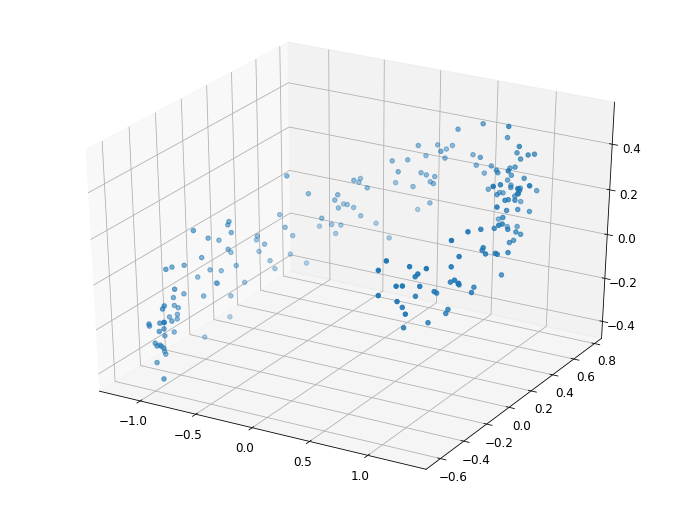

In [10]:
# Visulisisng the 3d data
fig = plt.figure(figsize=[12,9])
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2]);

In [15]:
import tensorflow as tf

n_inputs = 3
n_hidden = 2
n_outputs = 3

learning_rate = 0.1

# Define the architecture of the encoder

X = tf.placeholder(tf.float32 , shape = [None , n_inputs])
hidden = tf.layers.dense(X,n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

#Define loss function and optimizer
loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 100
codings = hidden

#Train the autoencoder
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train})
    codings_val = codings.eval(feed_dict={X:X_test})

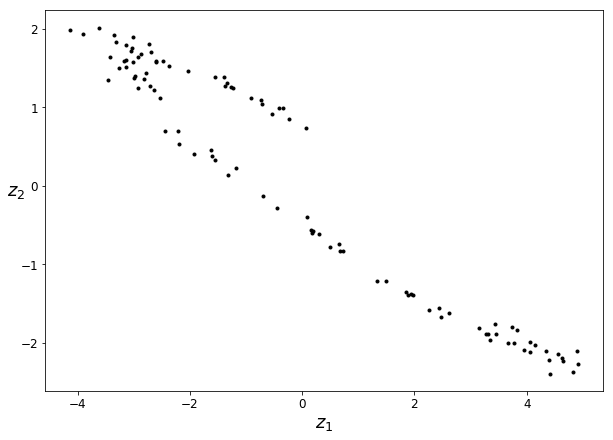

In [17]:
fig = plt.figure(figsize=[10,7])
plt.plot(codings_val[:,0],codings_val[:,1],'k.')
plt.xlabel('$z_1$',fontsize=18)
plt.ylabel('$z_2$',fontsize=18,rotation=0)
plt.show()

The auto encoder is able to preseeve the variance of the data and compute PCA principal component anaylysis on the data

# Stacked Auto-Encoders

just like neural networks auto-encoders can have multiple hidden layers. They are called stacked autoencoders. More number of hidden layer allow the network to learn complex features. However too many auto encoders can be used as hidden layers is likely to overfit the inputs hence autoencodere might not able to genralise well

In [20]:
#importing MNSIST data set
# MNSIT is database of handwritten digits
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [27]:
from functools import partial

n_inputs = 28 * 28 #required by MNIST
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32 , shape=[None , n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X,n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2)
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs,activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs -X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss]+reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [30]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end="")
            
            sys.stdout.flush()
            X_batch,y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        
        print("\r{}".format(epoch),"Train MSE:",loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.023356669
1 Train MSE: 0.012740442
2 Train MSE: 0.010633307
3 Train MSE: 0.010383655
4 Train MSE: 0.01061721


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


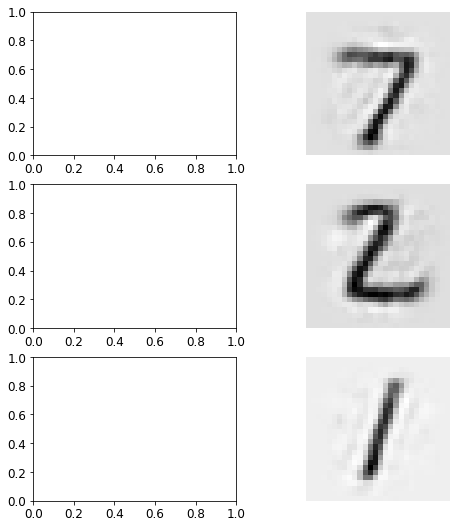

In [32]:
# reconstructed digits through autoencoder

def show_reconstructed_digits(X,outputs,model_path=None,n_test_digits=3):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess,model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict= {X:X_test})
        
    fig = plt.figure(figsize=(8,3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits,2,digit_index*2 + 1)
        plt.subplot(n_test_digits,2,digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(X,outputs,"./my_model_all_layers.ckpt")


# Variational Auto-Encoders

Variational autoencoders were introduced in 2014

Different from tradiational auto encoders in two ways:

-> they are probabalistic autoencoders, implying output are partly due by chance , even after training

-> they are generative autoencoders; they can generate new instances of data that look like the input

incase of variational autoencoders, they generate mean and standard devation from the input layer. Then the actual coding is sampled randomly from a Gaussian disturbution with the same mean and standard deviation
Then decoded normally to produce an output.

Further the cost function has a second part termed as latent loss.This ensures that auto encoder will hav codings that look as if sampled from a Gaussian Disturbution.


In [43]:
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 #codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001
initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
                    tf.layers.dense,
                    activation=tf.nn.elu,
                    kernel_initializer=initializer)

X = tf.placeholder(tf.float32 , [None , n_inputs])
hidden1 = my_dense_layer(X,n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype = tf.float32)

hidden3 = hidden3_mean + hidden3_sigma + noise

hidden4 = my_dense_layer(hidden3 , n_hidden3)
hidden5 = my_dense_layer(hidden4 , n_hidden5)
logits = my_dense_layer(hidden5 , n_outputs,activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X,logits = logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10

latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean)-1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
n_epochs = 50
batch_size = 150
n_digits= 60

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100*iteration // n_batches),end ="")
            
            sys.stdout.flush()
            X_batch , y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict= { X : X_batch})
            
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 25757.266 	Reconstruction loss: 22562.092 	Latent loss: 3195.1738
1 Train total loss: 27295.062 	Reconstruction loss: 20927.822 	Latent loss: 6367.24
2 Train total loss: 30761.438 	Reconstruction loss: 22256.766 	Latent loss: 8504.673
3 Train total loss: 24625.775 	Reconstruction loss: 19230.598 	Latent loss: 5395.178
4 Train total loss: 27924.438 	Reconstruction loss: 20925.367 	Latent loss: 6999.0693
5 Train total loss: 23341.81 	Reconstruction loss: 19541.36 	Latent loss: 3800.4507
6 Train total loss: 25498.033 	Reconstruction loss: 20417.754 	Latent loss: 5080.2793
7 Train total loss: 28072.059 	Reconstruction loss: 20521.451 	Latent loss: 7550.6064
8 Train total loss: 29791.127 	Reconstruction loss: 20331.957 	Latent loss: 9459.17
9 Train total loss: 23875.738 	Reconstruction loss: 19364.736 	Latent loss: 4511.0015
10 Train total loss: 29681.97 	Reconstruction loss: 20734.473 	Latent loss: 8947.498
11 Train total loss: 26466.867 	Reconstruction loss: 19757.69 	

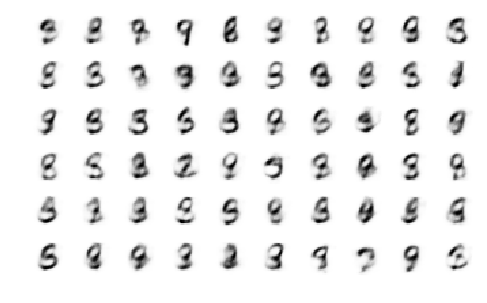

In [50]:
plt.figure(figsize=(8,50)) 
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])